In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False)
df=data['df']
df.head()

'y'

In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


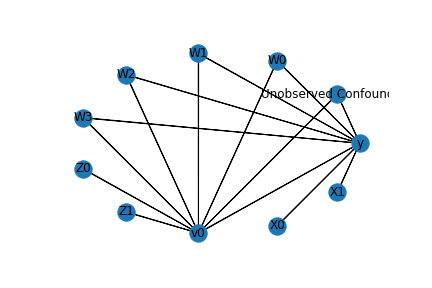

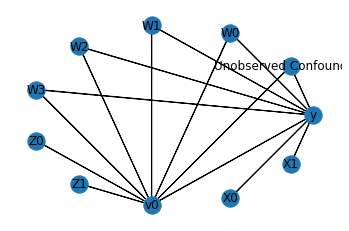

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W0', 'Unobserved Confounders', 'W3', 'W1']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W2,W0,W3,W1))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)



# Linear Model 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression")
print(linear_estimate) 

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W2,W0,W3,W1))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1
## Estimate
Value: 9.999999999999998



# EconML methods

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W2,W0,W3,W1))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1
## Estimate
Value: 13.521873861362502



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 12.075190677437128


### CATE Object and Confidence Intervals

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1, 
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals[:10])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W2,W0,W3,W1))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1
## Estimate
Value: 13.502655256019422

[[13.81300333]
 [10.60152527]
 [14.85982246]
 [20.68794592]
 [19.34161679]
 [11.35348627]
 [14.40524258]
 [15.73884334]
 [15.2332825 ]
 [10.36669607]]
(array([[13.50275702],
       [10.20164524],
       [14.54033512],
       [20.1709209 ],
       [18.8549497 ],
       [11.08664183],
       [14.08345713],
       [15.38348986],
       [14.89294134]

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


### Can also retrieve the raw EconML estimator object for any further operations

In [11]:
print(dml_estimate._estimator_object)
dml_estimate

# Works with any EconML method

In [12]:
## Continuous treatment, Continuous outcome

In [13]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, # not ideal, just as a test 
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.6min


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W2,W0,W3,W1))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1
## Estimate
Value: 13.305173559303652



[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  3.6min finished


## Continuous treatment, discrete outcome

In [14]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=False, outcome_is_binary=True)
print(data['df'])
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W0', 'Unobserved Confounders', 'W3', 'W1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.695459 -0.308142  0.0  0.996404 -1.707887 -0.279061  0.878231   
1    -1.315178 -1.188590  0.0  0.900700 -0.040841 -2.129343  1.491863   
2    -2.535321  0.809984  0.0  0.408458  1.084349  0.835592  1.306339   
3    -0.132261  0.283185  0.0  0.094959  0.027487  1.802634  0.892551   
4     0.808091  0.379436  0.0  0.379351 -0.805845 -0.526268  0.083688   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.026593 -0.985642  0.0  0.528419  0.637702  0.795069 -0.031651   
9996 -0.265366  0.863099  0.0  0.355897 -1.008987 -1.208703 -0.178591   
9997 -1.107576  0.108402  0.0  0.729760  1.123705 -0.552426 -0.522412   
9998 -1.107923 -0.516259  0.0  0.132783 -0.735121 -1.961753 -0.887083   
9999  0.142975  0.835341  0.0  0.417075 -0.498367 -1.087088  0.223509   

            W3         v0      y  
0     0.221413  -0.872259   True  
1     0.728573   1.922704   True  
2     0.782906  16

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.drlearner.LinearDRLearner",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

## Instrumental Variable Method

In [16]:
 import keras
from econml.deepiv import DeepIVEstimator
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W0+W3+W1


ValueError: Dimensions must be equal, but are 4 and 2 for 'sequential_1/dense_1/MatMul' (op: 'MatMul') with input shapes: [?,4], [2,128].

## Refuting the estimate

### Random 

In [ ]:
res_random=model.refute_estimate(identified_estimand, econml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, econml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

#### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

#### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)